In [1]:
import numpy as np 
import cvxopt
import cvxopt.solvers

In [3]:
cvxopt.solvers.options['show_progress'] = True

In [51]:
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False,polyconst=1,degree=2):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.kf = {
            "linear":self.linear,
            "poly":self.polynomial
        }
        
        self._support_vectors = None
        self._alphas = None
        self.intercept = None
        self._n_support = None
        self.weights = None
        self._support_labels = None
        self._indices = None
        
    def transform(self,X):
        K = np.zeros([X.shape[0],X.shape[0]])
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                K[i,j] = self.kf[self.kernel](X[i],X[j])
        return K
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn the SVM classifier. If verification data is input, the accuracy for it is also calculated for each iteration.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        num_data, num_features = X.shape
        labels = y.astype(np.double)
        K = self.transform(X)
        P = cvxopt.matrix(np.outer(labels,labels)*K)
        q = cvxopt.matrix(np.ones(num_data)*-1)
        A = cvxopt.matrix(labels,(1,num_data))
        b = cvxopt.matrix(0.0)
        G = cvxopt.matrix(np.diag(np.ones(num_data) * -1))
        h = cvxopt.matrix(np.zeros(num_data))

        alphas = np.ravel(cvxopt.solvers.qp(P, q, G, h, A, b)['x'])
        is_sv = alphas>1e-5
        self._support_vectors = X[is_sv]
        self._n_support = np.sum(is_sv)
        self._alphas = alphas[is_sv]
        self._support_labels = labels[is_sv]
        self._indices = np.arange(num_data)[is_sv]
        self.intercept = 0
#         print(self._n_support)
        for i in range(self._alphas.shape[0]):
            self.intercept += self._support_labels[i] 
            self.intercept -= np.sum(self._alphas*self._support_labels*K[self._indices[i],is_sv])
        self.intercept /= self._alphas.shape[0]
        self.weights = np.sum(X*labels.reshape(num_data,1)*alphas.reshape(num_data,1),axis=0,keepdims=True) if self.kernel == "linear" else None
#         if self.verbose: #verbose is set to True
#             print()
    
    def linear(self,x,y):
        return np.dot(x.T,y)

    def polynomial(self,x,y):
        return (np.dot(x.T,y) + self.polyconst)**self.degree
    
    def project(self,X):
        if self.kernel=="linear":
            score = np.dot(X,self.weights.T)+self.intercept
#             score = X*self.weights+self.intercept
        else:
            score = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                s = 0
                for alpha,label,sv in zip(self._alphas,self._support_labels,self._support_vectors):
                    s += alpha*label*self.kf[self.kernel](X[i],sv)
                score[i] = s
            score = score + self.intercept
        return score
    
    def signum(self,X):
        return np.where(X>0,1,-1)
    
    def predict(self, X):
        """
        Estimate the label using the SVM classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by SVM classifier
        """
  
        return self.signum(self.project(X))

In [52]:
import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

In [53]:
model = ScratchSVMClassifier(1000,0.003)

In [54]:
model.fit(X,y)

     pcost       dcost       gap    pres   dres
 0: -2.1118e+01 -3.4228e+01  1e+03  3e+01  2e+00
 1: -1.1499e+01 -1.9574e+00  7e+01  2e+00  1e-01
 2: -2.5979e-01 -8.0470e-01  9e-01  1e-02  4e-04
 3: -4.5453e-01 -6.5075e-01  3e-01  3e-03  1e-04
 4: -5.8608e-01 -6.4293e-01  6e-02  2e-04  1e-05
 5: -6.3522e-01 -6.3824e-01  3e-03  1e-05  5e-07
 6: -6.3797e-01 -6.3800e-01  3e-05  1e-07  5e-09
 7: -6.3800e-01 -6.3800e-01  3e-07  1e-09  5e-11
Optimal solution found.


In [55]:
from sklearn.metrics import classification_report

In [58]:
y_predict=model.predict(X)

In [57]:
# test = np.dot(X,model.weights.T)

In [50]:
# test.shape

(500, 1)

In [59]:
# y_predict

In [62]:
print(classification_report(y, y_predict, target_names=["label 1","label -1"]))

              precision    recall  f1-score   support

     label 1       1.00      1.00      1.00       250
    label -1       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

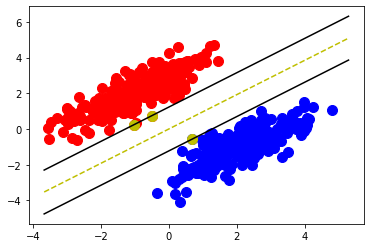

In [102]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = {1:'r',-1:'b'}
[ax.scatter(X[i][0],X[i][1],s=100,c=colors[y[i]],label = colors[y[i]]) for i in range(n_samples)]

[ax.scatter(model._support_vectors[i][0],model._support_vectors[i][1],s=100,c='y',label = "y") for i in range(model._n_support)]
def hyperplane(x,w,b,v):
    #returns a x2 value on line when given x1
    return (-w[0]*x-b+v)/w[1]

hyp_x_min= np.min(X)*0.9
hyp_x_max = np.max(X) *1.1

pav1 = hyperplane(hyp_x_min,model.weights[0],model.intercept,1)
pav2 = hyperplane(hyp_x_max,model.weights[0],model.intercept,1)
ax.plot([hyp_x_min,hyp_x_max],[pav1,pav2],'k')


nav1 = hyperplane(hyp_x_min,model.weights[0],model.intercept,-1)
nav2 = hyperplane(hyp_x_max,model.weights[0],model.intercept,-1)
ax.plot([hyp_x_min,hyp_x_max],[nav1,nav2],'k')

db1 = hyperplane(hyp_x_min,model.weights[0],model.intercept,0)
db2 = hyperplane(hyp_x_max,model.weights[0],model.intercept,0)
ax.plot([hyp_x_min,hyp_x_max],[db1,db2],'y--')

